In [1]:
# Standard library
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict
from itertools import chain

# Third-party libraries
import pyalex
from pyalex import Works, Institutions, Topics, Funders
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import igraph as ig

# Set up pyalex configuration
pyalex.config.email = "john.doe@gmail.com"

# Local project imports (src/ folder)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from load_data import read_parquet_as_dicts


data_path = (Path.cwd().parent / "data").resolve()

## Data

In [2]:
#funders = Funders().get()
# List fields of funders object
#print(funders[0].keys())

In [3]:
 #Define the filter criteria for works published in the USA
filter_criteria = {
    "from_publication_date": "2016-01-01",  # Start date
    "to_publication_date": "2020-03-15",    # End date
    "institutions": {"country_code": "us"},  # Filter for U.S.-based institutions
    "primary_location": {"source": {"type": "journal"}},  # Filter for journal articles
    "primary_topic": {"subfield": {"id": 2740}},  # Filter for Pulmonary and Respiratory Medicine
}


# Fetch the works with pagination
query = Works().filter(**filter_criteria)
all_works_16_20 = list(chain.from_iterable(query.paginate(per_page=200, n_max=None)))  # Adjust per_page as needed, n_max=None for all papers (heavy)

# Count the number of works
num_works_16_20 = len(all_works_16_20)

# Print the number of works
print(f"Number of works published in the USA in between 2016-2020: {num_works_16_20}")

# Optionally, print the first few works to verify
for work in all_works_16_20[:5]:  # Print the first 5 works as an example
    print(f"ID: {work['id']}, Title: {work['title']}, Publication Year: {work['publication_year']}")

Number of works published in the USA in between 2016-2020: 81354
ID: https://openalex.org/W2762087180, Title: Ferroptosis: A Regulated Cell Death Nexus Linking Metabolism, Redox Biology, and Disease, Publication Year: 2017
ID: https://openalex.org/W2286228001, Title: Epidemiology, Patterns of Care, and Mortality for Patients With Acute Respiratory Distress Syndrome in Intensive Care Units in 50 Countries, Publication Year: 2016
ID: https://openalex.org/W2770828094, Title: Osimertinib in Untreated<i>EGFR</i>-Mutated Advanced Non–Small-Cell Lung Cancer, Publication Year: 2017
ID: https://openalex.org/W2792937256, Title: Nivolumab plus Ipilimumab versus Sunitinib in Advanced Renal-Cell Carcinoma, Publication Year: 2018
ID: https://openalex.org/W2228221433, Title: The IASLC Lung Cancer Staging Project: Proposals for Revision of the TNM Stage Groupings in the Forthcoming (Eighth) Edition of the TNM Classification for Lung Cancer, Publication Year: 2016


In [13]:
#all_works_16_20[0]

{'id': 'https://openalex.org/W2762087180',
 'doi': 'https://doi.org/10.1016/j.cell.2017.09.021',
 'title': 'Ferroptosis: A Regulated Cell Death Nexus Linking Metabolism, Redox Biology, and Disease',
 'display_name': 'Ferroptosis: A Regulated Cell Death Nexus Linking Metabolism, Redox Biology, and Disease',
 'publication_year': 2017,
 'publication_date': '2017-10-01',
 'ids': {'openalex': 'https://openalex.org/W2762087180',
  'doi': 'https://doi.org/10.1016/j.cell.2017.09.021',
  'mag': '2762087180',
  'pmid': 'https://pubmed.ncbi.nlm.nih.gov/28985560',
  'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/5685180'},
 'language': 'en',
 'primary_location': {'is_oa': True,
  'landing_page_url': 'https://doi.org/10.1016/j.cell.2017.09.021',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S110447773',
   'display_name': 'Cell',
   'issn_l': '0092-8674',
   'issn': ['0092-8674', '1097-4172'],
   'is_oa': False,
   'is_in_doaj': False,
   'is_indexed_in_scopus': True,
   'is_core

In [3]:
#reading data
#all_works_16_20 = read_parquet_as_dicts(str(data_path) + "/all_works_16_20.parquet")
#print(f"{len(all_works_16_20)} articles in dataset")

81354 articles in dataset


#### Plotting the first 500 cited papers of 2016-2020

Their links might indicate the research clusters inside the field

In [4]:
import igraph as ig

# Step 1: Collect all unique work IDs
all_ids = set()
for work in all_works_16_20:
    all_ids.add(work['id'])
    references = work.get('referenced_works', [])
    if references:
        all_ids.update(references)  # Include referenced papers

# Step 2: Build the graph
g = ig.Graph(directed=True)
g.add_vertices(len(all_ids))  # Add the correct number of vertices

# Now set the "name" attribute manually
g.vs['name'] = list(all_ids)

# Step 3: Build edges
edges = []

# Create a fast lookup for names
existing_ids = set(g.vs['name'])

for work in all_works_16_20:
    src_id = work['id']
    references = work.get('referenced_works', [])
    if references:
        for ref_id in references:
            if ref_id in existing_ids:
                edges.append((src_id, ref_id))

g.add_edges(edges)

print(f"Graph built: {g.vcount()} nodes and {g.ecount()} edges.")

Graph built: 81385 nodes and 67894771 edges.


Subgraph: 500 nodes, 1145 edges


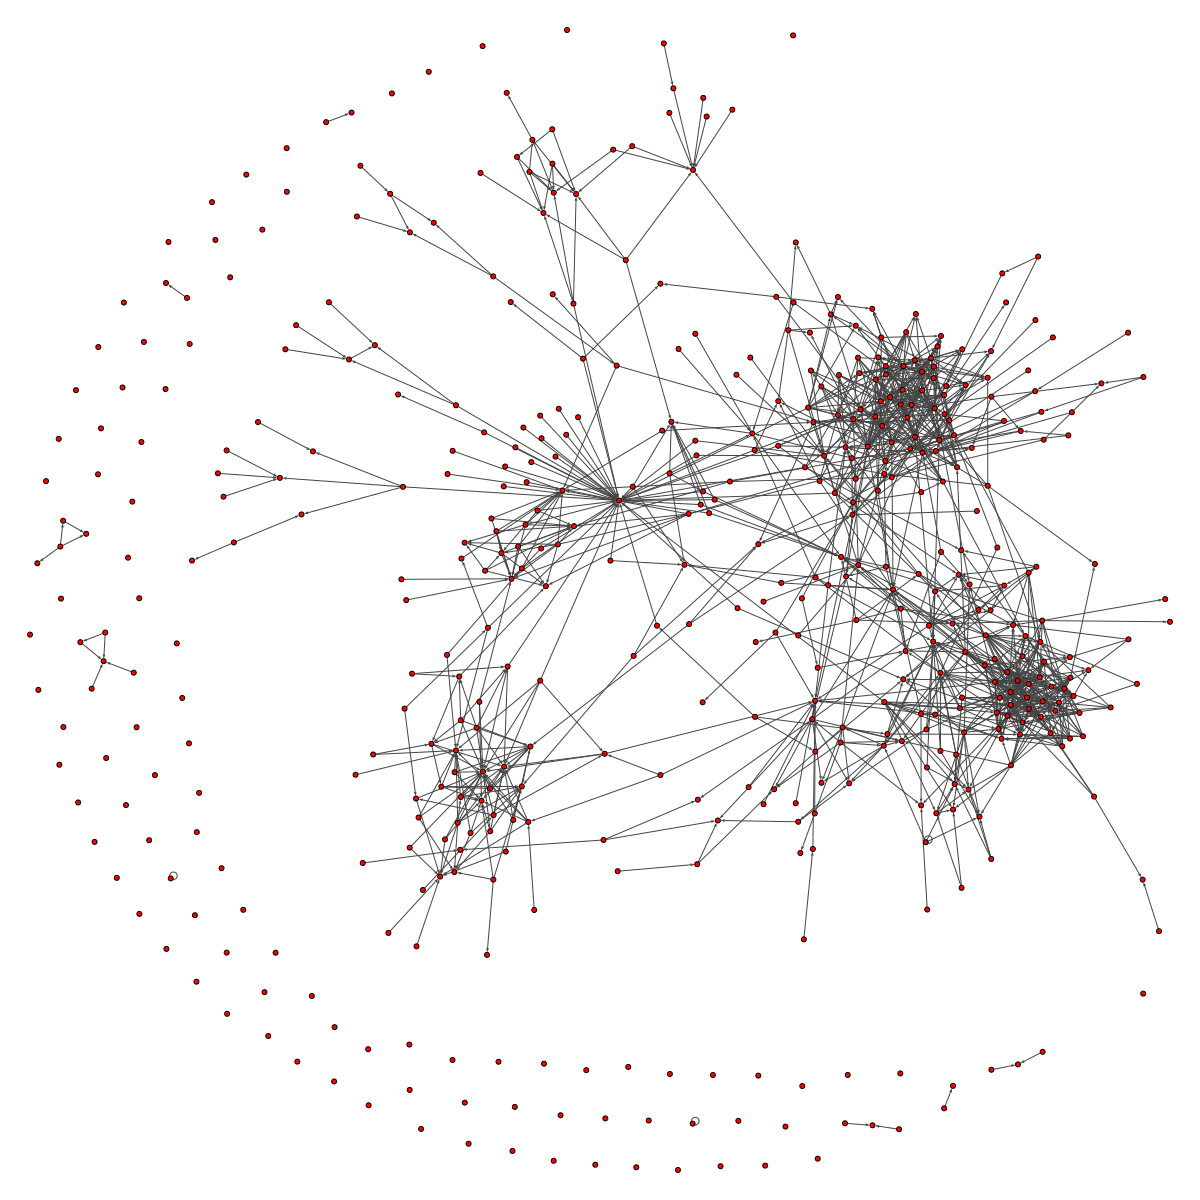

In [11]:
# Step 1: Compute node degrees
degrees = g.degree()

# Step 2: Get top nodes by degree
num_top_nodes = 500
top_indices = sorted(range(len(degrees)), key=lambda i: degrees[i], reverse=True)[:num_top_nodes]

# Step 3: Induced subgraph
subg = g.subgraph(top_indices)

print(f"Subgraph: {subg.vcount()} nodes, {subg.ecount()} edges")

# Step 4: Plot it
layout = subg.layout('fr')  # Fruchterman-Reingold layout
ig.plot(
    subg,
    layout=layout,
    vertex_size=5,
    edge_arrow_size=0.3,
    vertex_label=None,
    bbox=(1200, 1200),
    margin=30
)


## Collaboration coauthorship

In [11]:
# Create all_works_2018 with only works from 2018
all_works_2018 = [work for work in all_works_16_20 if work['publication_year'] == 2018]
num_works = len(all_works_2018)

# Count the number of unique work IDs
unique_work_ids = len(set(work['id'] for work in all_works_2018))
print(f"Number of unique work IDs: {unique_work_ids}")

In [13]:
# Construct a collaboration network with country information
G_collaboration = nx.Graph()

# Add nodes and edges for authors
for work in all_works_2018:
    authors = [
        (authorship['author']['id'], authorship['countries'])  # Assuming the first country is the primary one
        for authorship in work['authorships']
    ]
    for i, (author1, country1) in enumerate(authors):
        # Add author1 node with country attribute
        G_collaboration.add_node(author1, country=country1)
        for author2, country2 in authors[i + 1:]:
            # Add author2 node with country attribute
            G_collaboration.add_node(author2, country=country2)
            # Add edge between author1 and author2
            if G_collaboration.has_edge(author1, author2):
                G_collaboration[author1][author2]['weight'] += 1
            else:
                G_collaboration.add_edge(author1, author2, weight=1)

COAUTHORSHIP

In [14]:
# Number of nodes and edges in the collaboration network
num_nodes = G_collaboration.number_of_nodes()
num_edges = G_collaboration.number_of_edges()
print(f"Number of authors in the collaboration network: {num_nodes}")
print(f"Number of edges in the collaboration network: {num_edges}")
# Mean and median edges per node
mean_edges_per_node = np.mean([G_collaboration.degree(n) for n in G_collaboration.nodes()])
median_edges_per_node = np.median([G_collaboration.degree(n) for n in G_collaboration.nodes()])
print(f"Mean number of coauthors per author: {mean_edges_per_node}")
print(f"Median number of coauthors per author: {median_edges_per_node}")

Number of authors in the collaboration network: 82789
Number of edges in the collaboration network: 716444
Mean number of coauthors per author: 17.307709961468312
Median number of coauthors per author: 9.0


In [15]:
# Degree centrality
#degree_centrality = nx.degree_centrality(G_collaboration)
#top_collaborators = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
#print("Top collaborative authors by degree centrality:", top_collaborators)

# Betweenness centrality
#betweenness_centrality = nx.betweenness_centrality(G_collaboration)
#top_intermediaries = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
#print("Top intermediaries in the network by betweenness centrality:", top_intermediaries)

# Connected components
#connected_components = list(nx.connected_components(G_collaboration))
#print(f"Number of connected components: {len(connected_components)}")

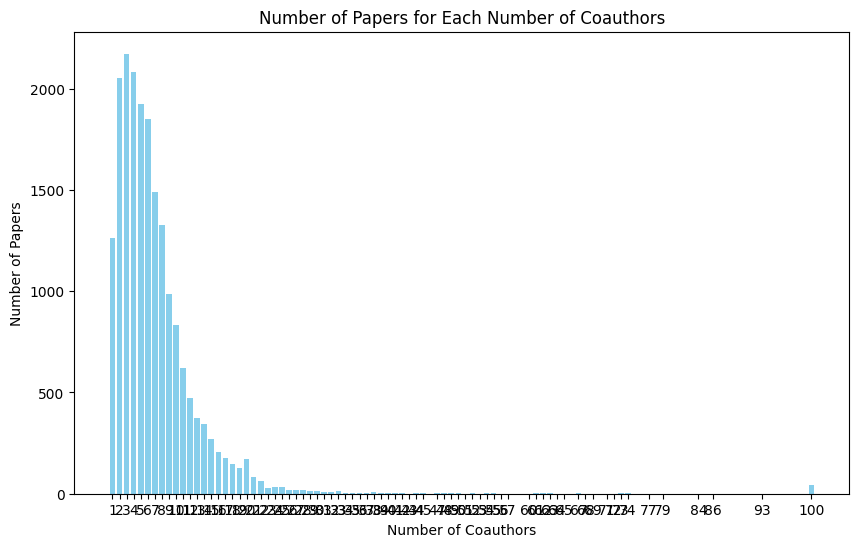

In [16]:
# Count the number of coauthors for each work
coauthor_counts = Counter(len(work['authorships']) for work in all_works_2018)

# Prepare data for plotting
coauthor_numbers = list(coauthor_counts.keys())
paper_counts = list(coauthor_counts.values())

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(coauthor_numbers, paper_counts, color='skyblue')
plt.xlabel('Number of Coauthors')
plt.ylabel('Number of Papers')
plt.title('Number of Papers for Each Number of Coauthors')
plt.xticks(coauthor_numbers)
plt.show()

In [17]:
#Mean and median number of coauthors per paper
mean_coauthors = np.mean([len(work['authorships']) for work in all_works_2018])
median_coauthors = np.median([len(work['authorships']) for work in all_works_2018])
print(f"Mean number of coauthors per paper: {mean_coauthors:.2f}")
print(f"Median number of coauthors per paper: {median_coauthors}")

Mean number of coauthors per paper: 7.13
Median number of coauthors per paper: 6.0


### Exposure to China

J'arrive pas à ajouter le pays dans le graph des auteurs

## Graph of Works

In [18]:
# Contruct a graph of funders and papers (nodes are funders and papers, edges are funding)
G_works = nx.Graph()
# Add nodes for each work and its funders
for work in all_works_2018:
    work_id = work['id']
    G_works.add_node(work_id, type='work')
    for grant in work['grants']:
        funder_name = grant['funder_display_name']
        G_works.add_node(funder_name, type='funder')
        G_works.add_edge(work_id, funder_name)
        # Add country to the funder type nodes
        if 'country_code' in grant:
            G_works.nodes[funder_name]['country'] = grant['country_code']
        else:
            # If country_code is not available, set a default value or skip
            G_works.nodes[funder_name]['country'] = 'Unknown'
# Add attributes to work nodes (citation count, has_chinese_coauthor, has_grant, etc.)
for work in all_works_2018:
    work_id = work['id']
    G_works.nodes[work_id]['cited_by_count'] = work['cited_by_count']
    G_works.nodes[work_id]['has_grant'] = len(work['grants']) > 0
# Add nodes for authors and edges between authors and papers
    for authorship in work['authorships']:
        author_id = authorship['author']['id']
        G_works.add_node(author_id, type='author')
        G_works.add_edge(work_id, author_id)
# Add attribute to work nodes (has_chinese_coauthor, has_not_american_coauthor, etc.)
    G_works.nodes[work_id]['has_not_american_coauthor'] = any('US' not in authorship['countries'] for authorship in work['authorships'])
    G_works.nodes[work_id]['has_chinese_coauthor'] = any('CN' in authorship['countries'] for authorship in work['authorships'])


### International collaboration

In [19]:
# Share of work nodes with only american coauthors, at least 1 foreign coauthor, at least 1 chinese coauthor
share_american_coauthors = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor']) / len(all_works_2018)
share_foreign_coauthors = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0 ) / len(all_works_2018)
share_chinese_coauthors = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor']) / len(all_works_2018)
print(f"Share of works with only American coauthors: {share_american_coauthors:.2%}")
print(f"Share of works with at least one foreign coauthor: {share_foreign_coauthors:.2%}")
print(f"Share of works with at least one Chinese coauthor: {share_chinese_coauthors:.2%}")

Share of works with only American coauthors: 32.35%
Share of works with at least one foreign coauthor: 67.65%
Share of works with at least one Chinese coauthor: 4.77%


### Quality of work

In [20]:
# Mean and median citation counts for works with or without international coauthors
mean_citations_with_international = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0])
mean_citations_without_international = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor']])
median_citations_with_international = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0])
median_citations_without_international = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor']])
print(f"Mean citation count for works with international coauthors: {mean_citations_with_international:.2f}")
print(f"Mean citation count for works without international coauthors: {mean_citations_without_international:.2f}")
print(f"Median citation count for works with international coauthors: {median_citations_with_international:.2f}")
print(f"Median citation count for works without international coauthors: {median_citations_without_international:.2f}")

Mean citation count for works with international coauthors: 16.94
Mean citation count for works without international coauthors: 36.79
Median citation count for works with international coauthors: 4.00
Median citation count for works without international coauthors: 10.00


In [21]:
# Mean and median citation counts for works with and without chinese coauthors
mean_citations_with_chinese = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor']])
mean_citations_without_chinese = np.mean([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'] == 0])
median_citations_with_chinese = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor']])
median_citations_without_chinese = np.median([G_works.nodes[work['id']]['cited_by_count'] for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'] == 0])
print(f"Mean citation count for works with Chinese coauthors: {mean_citations_with_chinese:.2f}")
print(f"Mean citation count for works without Chinese coauthors: {mean_citations_without_chinese:.2f}")
print(f"Median citation count for works with Chinese coauthors: {median_citations_with_chinese:.2f}")
print(f"Median citation count for works without Chinese coauthors: {median_citations_without_chinese:.2f}")

Mean citation count for works with Chinese coauthors: 36.96
Mean citation count for works without Chinese coauthors: 22.68
Median citation count for works with Chinese coauthors: 14.00
Median citation count for works without Chinese coauthors: 5.00


### Fundings

In [22]:
# Among US-only papers, at least 1 foreign coauthor, at least 1 Chinese coauthor: what share has a grant?
share_grant_with_international = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0 and G_works.nodes[work['id']]['has_grant']) / sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 0)
share_grant_without_international = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 1 and G_works.nodes[work['id']]['has_grant']) / sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_not_american_coauthor'] == 1)
share_grant_with_chinese = sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'] and G_works.nodes[work['id']]['has_grant']) / sum(1 for work in all_works_2018 if G_works.nodes[work['id']]['has_chinese_coauthor'])

print(f"Share of works with international coauthors that have a grant: {share_grant_with_international:.2%}")
print(f"Share of works without international coauthors that have a grant: {share_grant_without_international:.2%}")
print(f"Share of works with Chinese coauthors that have a grant: {share_grant_with_chinese:.2%}")

Share of works with international coauthors that have a grant: 13.00%
Share of works without international coauthors that have a grant: 18.29%
Share of works with Chinese coauthors that have a grant: 31.35%


In [23]:
# For works with at least 1 chinese coauthor, who are the funders?
USCN_funder_counts = Counter()
for work in all_works_2018:
    if G_works.nodes[work['id']]['has_chinese_coauthor']:
        for grant in work['grants']:
            funder_name = grant['funder_display_name']
            USCN_funder_counts[funder_name] += 1
# Print the top 10 funders for works with at least one Chinese coauthor
print("Funders for works with at least one Chinese coauthor:")
for funder, count in USCN_funder_counts.most_common(10):  # Print top 10 funders
    print(f"{funder}: {count} works")

Funders for works with at least one Chinese coauthor:
National Natural Science Foundation of China: 274 works
National Institutes of Health: 145 works
National Cancer Institute: 31 works
U.S. Department of Defense: 27 works
National Heart, Lung, and Blood Institute: 25 works
Natural Science Foundation of Guangdong Province: 24 works
China Scholarship Council: 17 works
National Key Research and Development Program of China: 12 works
Ministry of Science and Technology, Taiwan: 11 works
American Cancer Society: 10 works


In [24]:
# For works with at least 1 chinese coauthor, from which countries are the funders?
USCN_funder_country_counts = Counter()
for work in all_works_2018:
    if G_works.nodes[work['id']]['has_chinese_coauthor']:
        for grant in work['grants']:
            funder_country = G_works.nodes[grant['funder_display_name']]['country']
            USCN_funder_country_counts[funder_country] += 1
# Print the top 10 funder countries for works with at least one Chinese coauthor
print("Funder countries for works with at least one Chinese coauthor:")
for country, count in USCN_funder_country_counts.most_common(10):  # Print top 10 funder countries
    print(f"{country}: {count} works")

Funder countries for works with at least one Chinese coauthor:
Unknown: 866 works


In [19]:
# Density of the subgraph
density = nx.density(us_china_collaboration)
print(f"Density of U.S.-China collaboration subgraph: {density}")

# Bridges in the subgraph
bridges = list(nx.bridges(us_china_collaboration))
print(f"Number of bridges in U.S.-China collaboration subgraph: {len(bridges)}")
# edges whose removal disconnects the graph to find critical collaborations.

NameError: name 'us_china_collaboration' is not defined

In [25]:
# Get total number of unique institutions
unique_institutions = set()
for work in all_works_2018:
    for author in work['authorships']:
        for institution in author['institutions']:
            unique_institutions.add(institution['id'])
print(f"Total number of unique institutions: {len(unique_institutions)}")

Total number of unique institutions: 8341


Text(0.5, 0, 'Number of Institutions')

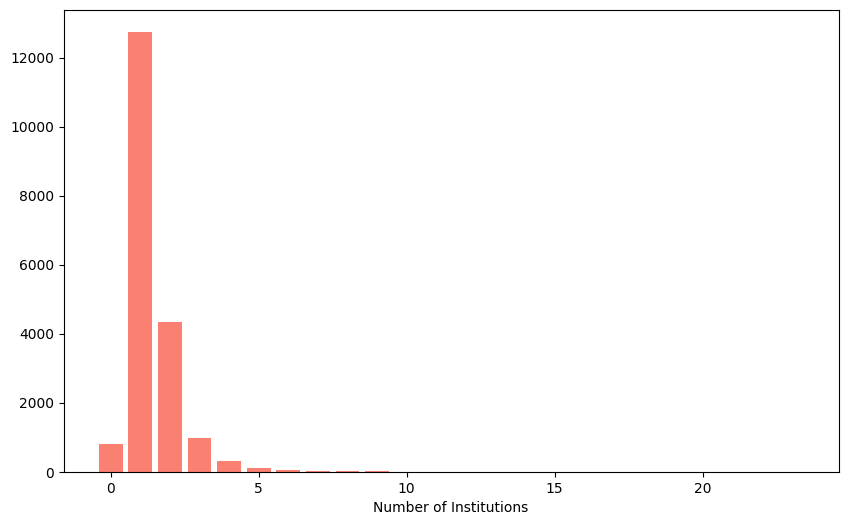

In [26]:
# Plot number of unique institutions per paper
institution_counts = Counter(len(work['authorships'][0]['institutions']) for work in all_works_2018)
institution_numbers = list(institution_counts.keys())
institution_paper_counts = list(institution_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(institution_numbers, institution_paper_counts, color='salmon')
plt.xlabel('Number of Institutions')

In [27]:
# For each work generate dummy variable if at least one coauthor is from china, add it to all_works_2018
for work in all_works_2018:
    work['has_chinese_coauthor'] = any('CN' in author['countries'] for author in work['authorships'])
# Count the number of works with at least one Chinese coauthor
num_works_with_chinese_coauthor = sum(work['has_chinese_coauthor'] for work in all_works_2018)
print(f"Number of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor}")
print(f"Percentage of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor / num_works * 100:.2f}%")

Number of works with at least one Chinese coauthor: 925
Percentage of works with at least one Chinese coauthor: 4.77%


In [28]:
# Count the number of Chinese coauthors
chinese_coauthors = sum(
    1
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') == 'CN'
)

# Print the result
print(f"Number of Chinese coauthors: {chinese_coauthors}")

Number of Chinese coauthors: 7252


In [29]:
#For each work generate dummy variable if all authors are from USA, add it to all_works_2018
for work in all_works_2018:
    work['all_authors_from_usa'] = all('US' in author['countries'] for author in work['authorships'])
# Count the number of works with all authors from the USA
num_works_all_authors_from_usa = sum(work['all_authors_from_usa'] for work in all_works_2018)
print(f"Number of works with all authors from the USA: {num_works_all_authors_from_usa}")

Number of works with all authors from the USA: 13111


## QUALITY OF RESEARCH

In [30]:
# Get min max mean and deciles of cited_by_count
cited_by_counts = [work['cited_by_count'] for work in all_works_2018]
min_cited_by_count = min(cited_by_counts)
max_cited_by_count = max(cited_by_counts)
mean_cited_by_count = np.mean(cited_by_counts)
deciles = np.percentile(cited_by_counts, np.arange(0, 101, 10))
print(f"Min cited_by_count: {min_cited_by_count}")
print(f"Max cited_by_count: {max_cited_by_count}")
print(f"Mean cited_by_count: {mean_cited_by_count:.2f}")
print(f"Deciles of cited_by_count: {deciles}")

Min cited_by_count: 0
Max cited_by_count: 3964
Mean cited_by_count: 23.36
Deciles of cited_by_count: [0.000e+00 0.000e+00 0.000e+00 1.000e+00 2.000e+00 5.000e+00 1.000e+01
 1.600e+01 2.700e+01 5.100e+01 3.964e+03]


<BarContainer object of 417 artists>

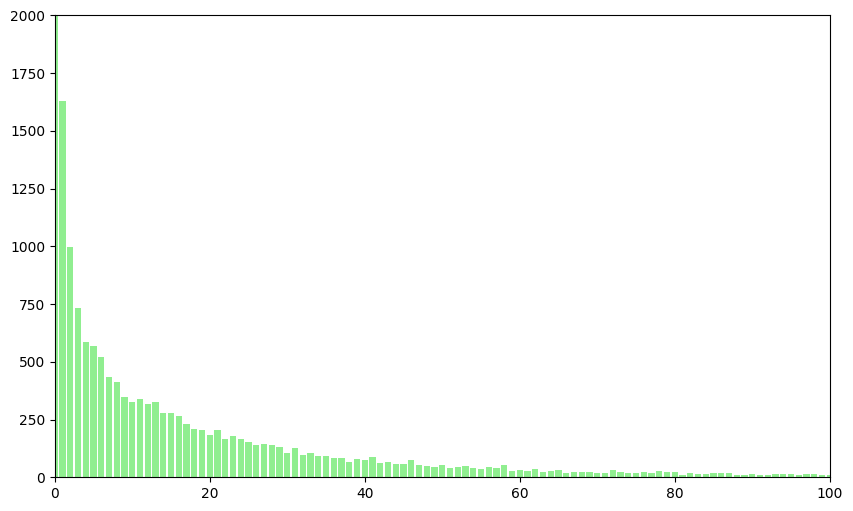

In [31]:
# Distribution of citations per paper
citations_counts = Counter(work['cited_by_count'] for work in all_works_2018)
# Prepare data for plotting
citation_numbers = list(citations_counts.keys())
citation_paper_counts = list(citations_counts.values())
# Plot the data
plt.figure(figsize=(10, 6))
plt.xlim(0, 100)
plt.ylim(0, 2000)
plt.bar(citation_numbers, citation_paper_counts, color='lightgreen')

In [32]:
#Mean citations for paperss with and without Chinese coauthors
mean_citations_with_chinese = np.mean([work['cited_by_count'] for work in all_works_2018 if work['has_chinese_coauthor']])
mean_citations_without_chinese = np.mean([work['cited_by_count'] for work in all_works_2018 if not work['has_chinese_coauthor']])
print(f"Mean citations for papers with Chinese coauthors: {mean_citations_with_chinese:.2f}")
print(f"Mean citations for papers without Chinese coauthors: {mean_citations_without_chinese:.2f}")

Mean citations for papers with Chinese coauthors: 36.96
Mean citations for papers without Chinese coauthors: 22.68


### EXPOSURE TO POLICY

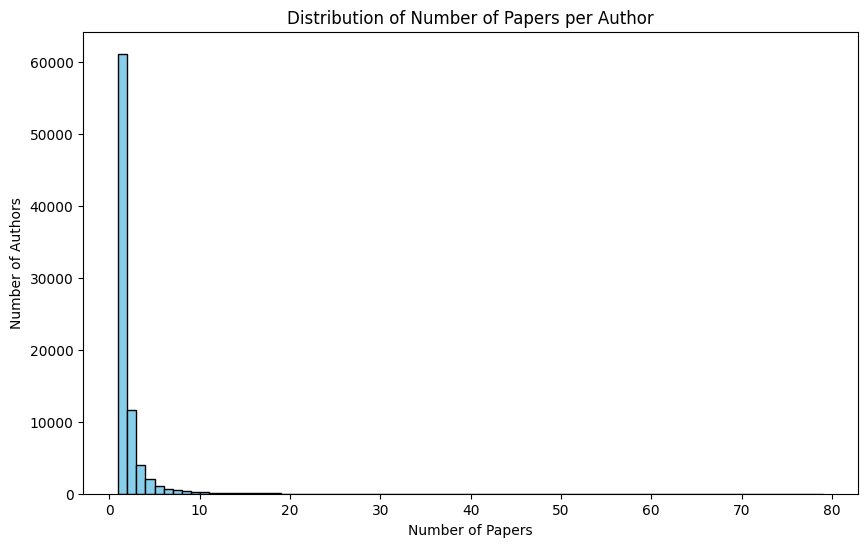

In [33]:
# Count the number of papers per author
author_paper_counts = Counter(
    authorship['author']['id']
    for work in all_works_2018
    for authorship in work['authorships']
)

# Prepare data for plotting
authors = list(author_paper_counts.keys())
paper_counts = list(author_paper_counts.values())

# Plot the data
plt.figure(figsize=(10, 6))
plt.hist(paper_counts, bins=range(1, max(paper_counts) + 2), color='skyblue', edgecolor='black')
plt.xlabel('Number of Papers')
plt.ylabel('Number of Authors')
plt.title('Distribution of Number of Papers per Author')
plt.show()

Text(0.5, 1.0, 'Distribution of Share of Papers with Chinese Coauthors for US Authors')

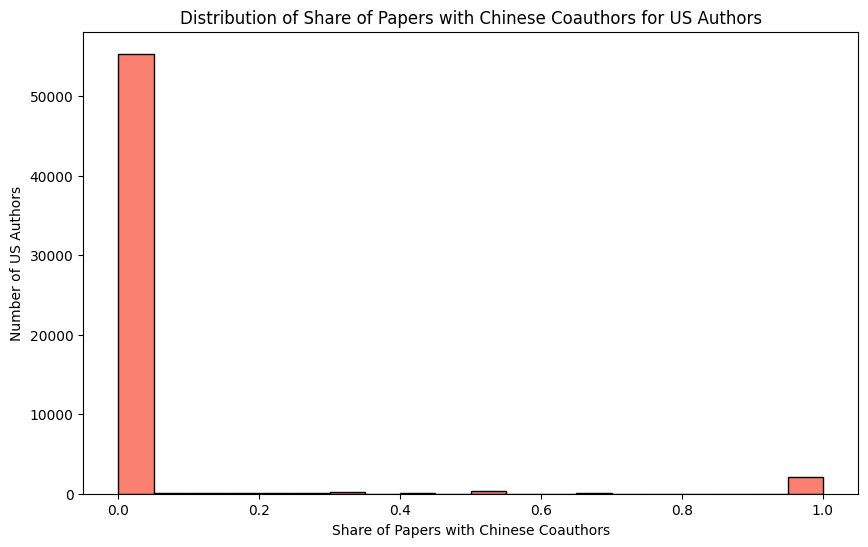

In [34]:
# For each US author compute share of papers with Chinese coauthors
for work in all_works_2018:
    for authorship in work['authorships']:
        if 'US' in authorship['countries']:
            authorship['has_chinese_coauthor'] = any('CN' in author['countries'] for author in work['authorships'])
# Count the number of papers for each US author
us_author_paper_counts = defaultdict(int)
for work in all_works_2018:
    for authorship in work['authorships']:
        if 'US' in authorship['countries']:
            us_author_paper_counts[authorship['author']['id']] += 1
# Compute the share of papers with Chinese coauthors for each US author
us_author_chinese_coauthor_counts = defaultdict(int)
for work in all_works_2018:
    for authorship in work['authorships']:
        if 'US' in authorship['countries'] and authorship.get('has_chinese_coauthor'):
            us_author_chinese_coauthor_counts[authorship['author']['id']] += 1
# Compute the share of papers with Chinese coauthors for each US author
us_author_shares = {
    author_id: us_author_chinese_coauthor_counts[author_id] / count
    for author_id, count in us_author_paper_counts.items()
}
# Prepare data for plotting
us_author_ids = list(us_author_shares.keys())
us_author_share_values = list(us_author_shares.values())
# Plot the data
plt.figure(figsize=(10, 6))
plt.hist(us_author_share_values, bins=20, color='salmon', edgecolor='black')
plt.xlabel('Share of Papers with Chinese Coauthors')
plt.ylabel('Number of US Authors')
plt.title('Distribution of Share of Papers with Chinese Coauthors for US Authors')

In [35]:
#List US authors with share of papers with Chinese coauthors > 0.5
high_share_authors = [author_id for author_id, share in us_author_shares.items() if share > 0.5]

## CHINA INITIATIVE

In [36]:
# Define the filter criteria for works published in the USA in 2020
filter_criteria = {
    "publication_year": 2019,  # Filter for works published in 2020
    "institutions": {"country_code": "us"},
    "primary_location": {"source": {"type": "journal"}},  # Filter for journal articles
    #"primary_topic": {"domain": {"id": 4}},  # Filter for Health science
    "primary_topic": {"subfield": {"id": 2740}},  # Filter for Pulmonary and Respiratory Medicine
}

# Fetch the works with pagination
query = Works().filter(**filter_criteria)
all_works_2019 = list(chain.from_iterable(query.paginate(per_page=200, n_max=None)))  # Adjust per_page as needed, n_max=None for all papers (heavy)

# Count the number of works
num_works = len(all_works_2019)

# Print the number of works
print(f"Number of works published in the USA in 2020: {num_works}")

# Optionally, print the first few works to verify
for work in all_works_2019[:5]:  # Print the first 5 works as an example
    print(f"ID: {work['id']}, Title: {work['title']}, Publication Year: {work['publication_year']}")

Number of works published in the USA in 2020: 20119
ID: https://openalex.org/W2907514116, Title: Reference-based analysis of lung single-cell sequencing reveals a transitional profibrotic macrophage, Publication Year: 2019
ID: https://openalex.org/W2925446385, Title: Pembrolizumab versus chemotherapy for previously untreated, PD-L1-expressing, locally advanced or metastatic non-small-cell lung cancer (KEYNOTE-042): a randomised, open-label, controlled, phase 3 trial, Publication Year: 2019
ID: https://openalex.org/W2913745075, Title: Pembrolizumab plus Axitinib versus Sunitinib for Advanced Renal-Cell Carcinoma, Publication Year: 2019
ID: https://openalex.org/W2980472864, Title: The CoQ oxidoreductase FSP1 acts parallel to GPX4 to inhibit ferroptosis, Publication Year: 2019
ID: https://openalex.org/W2937483840, Title: Epidemiology of Prostate Cancer, Publication Year: 2019


In [37]:
# For each work generate dummy variable if at least one coauthor is from china, add it to all_works_2020
for work in all_works_2019:
    work['has_chinese_coauthor'] = any('CN' in author['countries'] for author in work['authorships'])
# Count the number of works with at least one Chinese coauthor
num_works_with_chinese_coauthor = sum(work['has_chinese_coauthor'] for work in all_works_2019)
print(f"Number of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor}")
print(f"Percentage of works with at least one Chinese coauthor: {num_works_with_chinese_coauthor / num_works * 100:.2f}%")

Number of works with at least one Chinese coauthor: 950
Percentage of works with at least one Chinese coauthor: 4.72%


In [38]:
all_works_2019[0]['grants']

[]

In [39]:
len(all_works_2019[0]['grants'])

0

In [40]:
# Add dummy variable for each work if it has a grant
for work in all_works_2019:
    work['has_grant'] = len(work['grants']) > 0
# Count the number of works with at least one grant
num_works_with_grant = sum(work['has_grant'] for work in all_works_2019)
print(f"Number of works with at least one grant: {num_works_with_grant}")

Number of works with at least one grant: 3339


Text(0.5, 1.0, 'Number of Papers for Each Number of Grants')

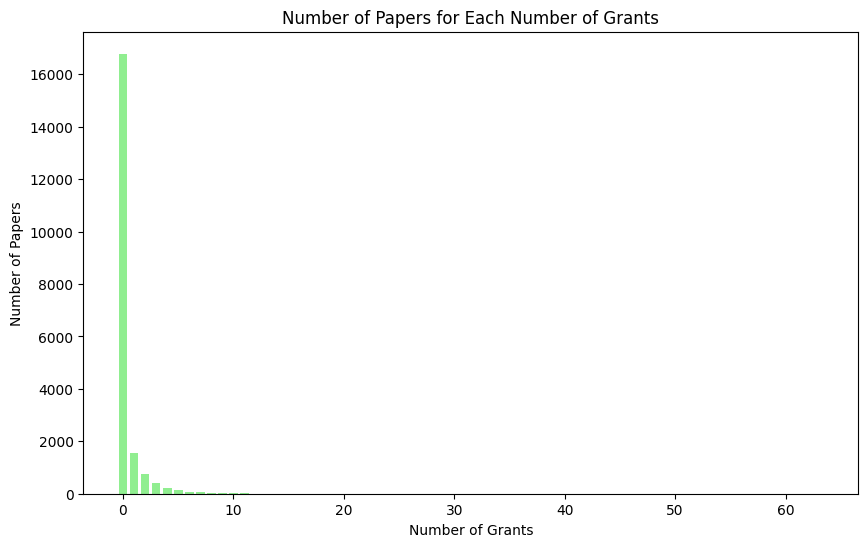

In [41]:
# Plot size of grants per paper
grant_counts = Counter(len(work['grants']) for work in all_works_2019)
# Prepare data for plotting
grant_numbers = list(grant_counts.keys())
grant_paper_counts = list(grant_counts.values())
# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(grant_numbers, grant_paper_counts, color='lightgreen')
plt.xlabel('Number of Grants')
plt.ylabel('Number of Papers')
plt.title('Number of Papers for Each Number of Grants')

In [42]:
# Comprend pas pourquoi ca marche pas (voir cellule suivante -> il y a grants)
all_works_2019['id' == 'https://openalex.org/W2990041408']['has_grant']

False

In [43]:
# Print works with grants
#for work in all_works_2019:
#   if len(work['grants']) > 0:
#        print(f"ID: {work['id']}, Has Grant: {work['has_grant']}, Grant: {work['grants']}")

In [44]:
# Print funder names and their counts
funder_counts = Counter()
for work in all_works_2019:
    for grant in work['grants']:
        funder_counts[grant['funder_display_name']] += 1
# Print the funder names and their counts
for funder, count in funder_counts.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")

Funder: National Institutes of Health, Count: 1479
Funder: National Cancer Institute, Count: 603
Funder: National Heart, Lung, and Blood Institute, Count: 523
Funder: National Natural Science Foundation of China, Count: 317
Funder: U.S. Department of Defense, Count: 142
Funder: Cystic Fibrosis Foundation, Count: 138
Funder: National Center for Advancing Translational Sciences, Count: 116
Funder: American Heart Association, Count: 101
Funder: National Institute of Diabetes and Digestive and Kidney Diseases, Count: 100
Funder: AstraZeneca, Count: 86


In [45]:
# Number of funders in funder_counts
num_funders = len(funder_counts)
print(f"Number of funders: {num_funders}")

Number of funders: 1293


In [46]:
# Top funders of works with Chinese coauthors vs without Chinese coauthors
funder_counts_with_chinese = Counter()
funder_counts_without_chinese = Counter()
for work in all_works_2019:
    for grant in work['grants']:
        if work['has_chinese_coauthor']:
            funder_counts_with_chinese[grant['funder_display_name']] += 1
        else:
            funder_counts_without_chinese[grant['funder_display_name']] += 1
# Print the top funders for works with Chinese coauthors
print("Top funders for works with Chinese coauthors:")
for funder, count in funder_counts_with_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")
# Print the top funders for works without Chinese coauthors
print("Top funders for works without Chinese coauthors:")
for funder, count in funder_counts_without_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")

Top funders for works with Chinese coauthors:
Funder: National Natural Science Foundation of China, Count: 317
Funder: National Institutes of Health, Count: 125
Funder: National Cancer Institute, Count: 30
Funder: National Heart, Lung, and Blood Institute, Count: 22
Funder: U.S. Department of Defense, Count: 20
Funder: Natural Science Foundation of Guangdong Province, Count: 15
Funder: National Institute on Aging, Count: 12
Funder: China Scholarship Council, Count: 12
Funder: Natural Science Foundation of Shandong Province, Count: 12
Funder: Natural Science Foundation of Tianjin City, Count: 11
Top funders for works without Chinese coauthors:
Funder: National Institutes of Health, Count: 1354
Funder: National Cancer Institute, Count: 573
Funder: National Heart, Lung, and Blood Institute, Count: 501
Funder: Cystic Fibrosis Foundation, Count: 133
Funder: U.S. Department of Defense, Count: 122
Funder: National Center for Advancing Translational Sciences, Count: 114
Funder: American Heart 

In [47]:
# Top funders of works with Chinese coauthors vs without Chinese coauthors
funder_counts_with_chinese = Counter()
funder_counts_without_chinese = Counter()
for work in all_works_2018:

    for grant in work['grants']:
        if work['has_chinese_coauthor']:
            funder_counts_with_chinese[grant['funder_display_name']] += 1
        else:
            funder_counts_without_chinese[grant['funder_display_name']] += 1
# Print the top funders for works with Chinese coauthors
print("Top funders for works with Chinese coauthors:")
for funder, count in funder_counts_with_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")
# Print the top funders for works without Chinese coauthors
print("Top funders for works without Chinese coauthors:")
for funder, count in funder_counts_without_chinese.most_common(10):  # Print top 10 funders
    print(f"Funder: {funder}, Count: {count}")

Top funders for works with Chinese coauthors:
Funder: National Natural Science Foundation of China, Count: 274
Funder: National Institutes of Health, Count: 145
Funder: National Cancer Institute, Count: 31
Funder: U.S. Department of Defense, Count: 27
Funder: National Heart, Lung, and Blood Institute, Count: 25
Funder: Natural Science Foundation of Guangdong Province, Count: 24
Funder: China Scholarship Council, Count: 17
Funder: National Key Research and Development Program of China, Count: 12
Funder: Ministry of Science and Technology, Taiwan, Count: 11
Funder: American Cancer Society, Count: 10
Top funders for works without Chinese coauthors:
Funder: National Institutes of Health, Count: 1340
Funder: National Heart, Lung, and Blood Institute, Count: 553
Funder: National Cancer Institute, Count: 502
Funder: Cystic Fibrosis Foundation, Count: 137
Funder: National Center for Advancing Translational Sciences, Count: 115
Funder: U.S. Department of Defense, Count: 104
Funder: National Ins

Introducing more info on fundings

## Construct networks

ne marche pas (G_fundings non défini avant)

In [48]:
# Count number of funder nodes in the graph
#num_funder_nodes = sum(1 for node, data in G_fundings.nodes(data=True) if data['type'] == 'funder')
#print(f"Number of funder nodes in the graph: {num_funder_nodes}")

ne marche pas (G_fundings non défini avant)

In [49]:
# Count number of author nodes in the graph
#num_author_nodes = sum(1 for node, data in G_fundings.nodes(data=True) if data['type'] == 'author')
#print(f"Number of author nodes in the graph: {num_author_nodes}")

In [50]:
# Count the number of authors for each work and store in all_works_2019
for work in all_works_2019:
    work['num_authors'] = len(work['authorships'])
#get total number of authors
total_coauthors = sum(work['num_authors'] for work in all_works_2019)
#get total of unique authors
unique_authors = set()
for work in all_works_2019:
    for author in work['authorships']:
        unique_authors.add(author['author']['id'])

print(f"Total number of authors: {total_coauthors}")
print(f"Total number of unique authors: {len(unique_authors)}")

Total number of authors: 147896
Total number of unique authors: 88281


SURPLUS

In [51]:
# Extract all unique country codes of co-authors
country_codes = set(
    inst.get('country_code') 
    for work in all_works_2018 
    for authorship in work['authorships'] 
    for inst in authorship.get('institutions', []) 
    if 'country_code' in inst
)

# Print the unique country codes
print(f"Different country codes of co-authors: {country_codes}")

Different country codes of co-authors: {'UZ', 'OM', 'SK', 'CM', 'LK', 'MO', 'BW', 'SI', 'ZW', 'DK', None, 'VE', 'ZM', 'PL', 'BE', 'PH', 'CN', 'AR', 'IQ', 'KE', 'MN', 'PY', 'NL', 'CO', 'CY', 'NP', 'BD', 'DM', 'GB', 'BR', 'CR', 'EE', 'ID', 'BB', 'NZ', 'VN', 'SS', 'IL', 'SA', 'BG', 'YE', 'GR', 'PS', 'SE', 'BY', 'TN', 'MT', 'GH', 'CA', 'TZ', 'CZ', 'CL', 'GU', 'KR', 'IE', 'PR', 'AE', 'MM', 'RO', 'MW', 'JP', 'GP', 'ES', 'CU', 'PT', 'AZ', 'MZ', 'MY', 'DE', 'UA', 'EC', 'AT', 'NO', 'SG', 'IS', 'UY', 'DZ', 'LB', 'CH', 'HR', 'FI', 'BS', 'IR', 'LT', 'PE', 'FR', 'AL', 'US', 'MQ', 'LV', 'GD', 'PK', 'KH', 'MA', 'EG', 'TR', 'RU', 'JO', 'RS', 'SY', 'HU', 'RW', 'JM', 'AU', 'GE', 'TT', 'NG', 'ET', 'QA', 'KW', 'PA', 'AM', 'UG', 'IT', 'RE', 'MK', 'TH', 'DO', 'TW', 'TJ', 'IN', 'KG', 'BA', 'KZ', 'HK', 'ZA', 'MC', 'MX', 'AF', 'MD', 'LU'}


In [52]:
# Count institutions in the US and outside the US
us_institutions = set(
    inst['id']
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') == 'US'
)

non_us_institutions = set(
    inst['id']
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') != 'US'
)

cn_institutions = set(
    inst['id']
    for work in all_works_2018
    for authorship in work['authorships']
    for inst in authorship.get('institutions', [])
    if inst.get('country_code') == 'CN'
)

# Print the results
print(f"Number of institutions in the US: {len(us_institutions)}")
print(f"Number of institutions outside the US: {len(non_us_institutions)}")
print(f"Number of institutions in China: {len(cn_institutions)}")

Number of institutions in the US: 3394
Number of institutions outside the US: 4947
Number of institutions in China: 514


## Assessing first order effects 

Top x%, jouer avec les dates de filtre

Selected 436 top China-collaborating US authors.
         pre_pubs   post_pubs  pre_china_share  post_china_share  \
count  436.000000  436.000000       436.000000        169.000000   
mean     3.222477    0.876147         0.984984          0.703517   
std      2.648539    1.788412         0.064101          0.419761   
min      2.000000    0.000000         0.500000          0.000000   
25%      2.000000    0.000000         1.000000          0.333333   
50%      2.000000    0.000000         1.000000          1.000000   
75%      3.000000    1.000000         1.000000          1.000000   
max     24.000000   14.000000         1.000000          1.000000   

       pre_foreign_share  post_foreign_share  pre_mean_citations  \
count         436.000000          169.000000          436.000000   
mean            0.290494            0.314596           63.080518   
std             0.385110            0.419274          144.500511   
min             0.000000            0.000000            0.000000  

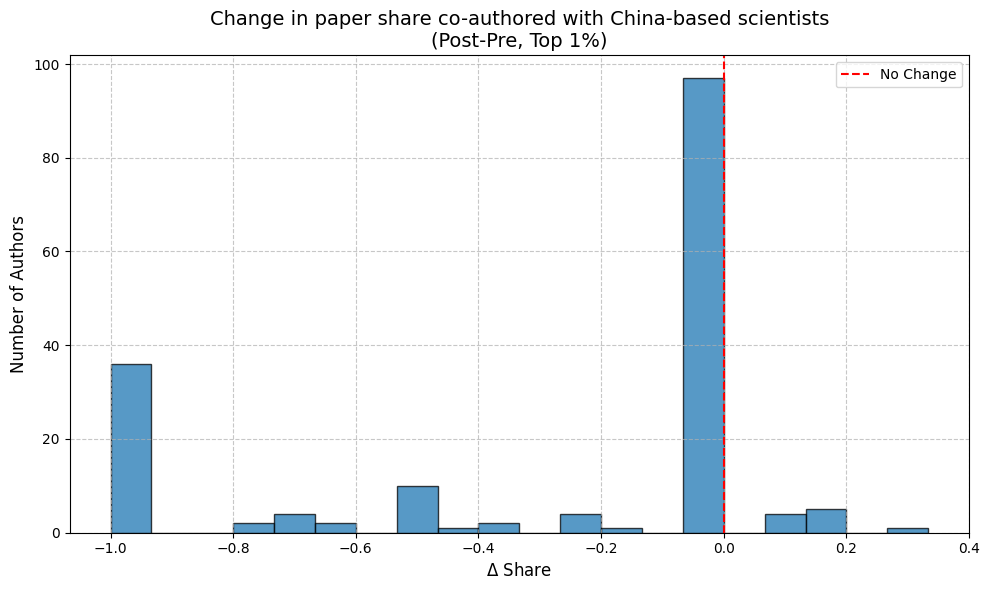

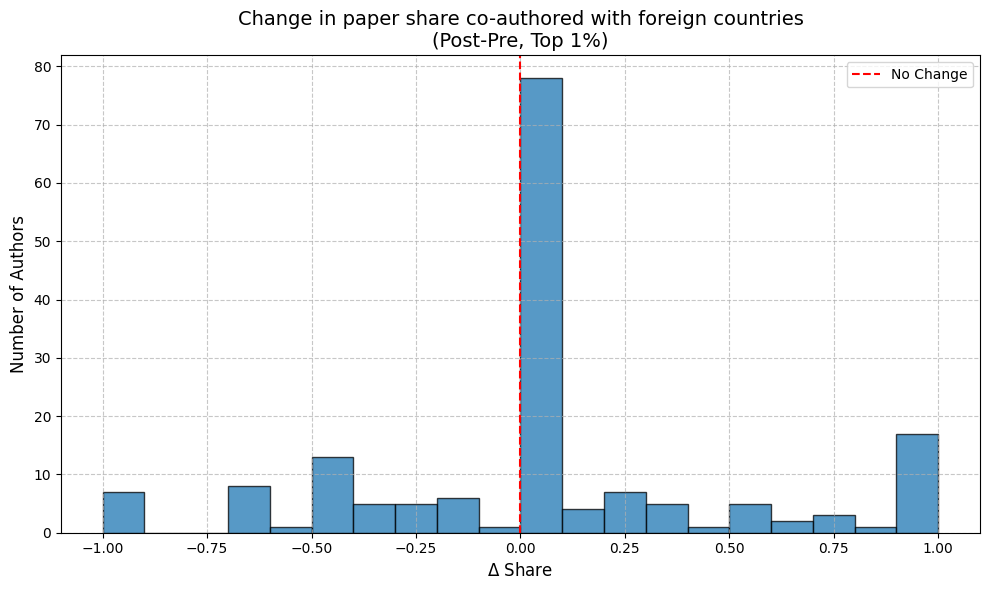

In [55]:
import numpy as np
import pandas as pd
from collections import defaultdict

# ========================
# Step 1: Select Top X% of China-collaborating US researchers (before Nov 2018)
# ========================

# Build US authors + share of papers with Chinese coauthors
us_author_total_papers_pre = defaultdict(int)
us_author_chinese_papers_pre = defaultdict(int)

for work in all_works_16_20:  # assuming you already have all works 2016-2020
    if work['publication_year'] < 2019:  # Before Nov 2018 => anything up to 2018
        for authorship in work['authorships']:
            if 'US' in authorship['countries']:
                us_author_total_papers_pre[authorship['author']['id']] += 1
                if any('CN' in coauth['countries'] for coauth in work['authorships']):
                    us_author_chinese_papers_pre[authorship['author']['id']] += 1

# Compute share of China collaboration
us_author_china_share = {
    author_id: us_author_chinese_papers_pre[author_id] / us_author_total_papers_pre[author_id]
    for author_id in us_author_total_papers_pre
    if us_author_total_papers_pre[author_id] >= 2  # filter for active researchers
}

# Find top X% most China-collaborative authors
top_percentage = 1
threshold = np.percentile(list(us_author_china_share.values()), 100 - top_percentage)
top_china_authors = {author_id for author_id, share in us_author_china_share.items() if share >= threshold}

print(f"Selected {len(top_china_authors)} top China-collaborating US authors.")

# ========================
# Step 2: Track outcomes before vs after Nov 2018
# ========================

# Initialize metrics
author_metrics = defaultdict(lambda: {
    'pre_pubs': 0, 'post_pubs': 0,
    'pre_china_pubs': 0, 'post_china_pubs': 0,
    'pre_other_foreign_pubs': 0, 'post_other_foreign_pubs': 0,
    'pre_citations': [], 'post_citations': []
})

for work in all_works_16_20:
    year = work['publication_year']
    if year < 2016 or year > 2020:
        continue  # skip

    is_pre = (year <= 2018)  # Pre-shock = 2016–2018
    is_post = (year >= 2019)  # Post-shock = 2019–2020

    has_chinese_coauthor = any('CN' in auth['countries'] for auth in work['authorships'])
    has_other_foreign_coauthor = any(
        c not in ['US', 'CN'] for auth in work['authorships'] for c in auth['countries']
    )

    for authorship in work['authorships']:
        author_id = authorship['author']['id']
        if author_id in top_china_authors:
            if is_pre:
                author_metrics[author_id]['pre_pubs'] += 1
                if has_chinese_coauthor:
                    author_metrics[author_id]['pre_china_pubs'] += 1
                if has_other_foreign_coauthor:
                    author_metrics[author_id]['pre_other_foreign_pubs'] += 1
                author_metrics[author_id]['pre_citations'].append(work['cited_by_count'])
            elif is_post:
                author_metrics[author_id]['post_pubs'] += 1
                if has_chinese_coauthor:
                    author_metrics[author_id]['post_china_pubs'] += 1
                if has_other_foreign_coauthor:
                    author_metrics[author_id]['post_other_foreign_pubs'] += 1
                author_metrics[author_id]['post_citations'].append(work['cited_by_count'])

# ========================
# Step 3: Prepare clean table
# ========================

# Build a dataframe
rows = []
for author_id, metrics in author_metrics.items():
    rows.append({
        'author_id': author_id,
        'pre_pubs': metrics['pre_pubs'],
        'post_pubs': metrics['post_pubs'],
        'pre_china_share': metrics['pre_china_pubs'] / metrics['pre_pubs'] if metrics['pre_pubs'] > 0 else np.nan,
        'post_china_share': metrics['post_china_pubs'] / metrics['post_pubs'] if metrics['post_pubs'] > 0 else np.nan,
        'pre_foreign_share': metrics['pre_other_foreign_pubs'] / metrics['pre_pubs'] if metrics['pre_pubs'] > 0 else np.nan,
        'post_foreign_share': metrics['post_other_foreign_pubs'] / metrics['post_pubs'] if metrics['post_pubs'] > 0 else np.nan,
        'pre_mean_citations': np.mean(metrics['pre_citations']) if metrics['pre_citations'] else np.nan,
        'post_mean_citations': np.mean(metrics['post_citations']) if metrics['post_citations'] else np.nan,
    })

df_metrics = pd.DataFrame(rows)

# ========================
# Step 4: Analysis
# ========================

# Change in collaborations
df_metrics['delta_china_share'] = df_metrics['post_china_share'] - df_metrics['pre_china_share']
df_metrics['delta_foreign_share'] = df_metrics['post_foreign_share'] - df_metrics['pre_foreign_share']

# Change in publications
df_metrics['delta_pubs'] = df_metrics['post_pubs'] - df_metrics['pre_pubs']

# Change in citations
df_metrics['delta_mean_citations'] = df_metrics['post_mean_citations'] - df_metrics['pre_mean_citations']

# Summary
print(df_metrics.describe())

import matplotlib.pyplot as plt

# Settings
figsize = (10, 6)
bins = 20
alpha = 0.75
edgecolor = 'black'

# Plot for China collaboration share
plt.figure(figsize=figsize)
plt.hist(df_metrics['delta_china_share'].dropna(), bins=bins, alpha=alpha, edgecolor=edgecolor)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5, label='No Change')
plt.title(f'Change in paper share co-authored with China-based scientists\n(Post-Pre, Top {top_percentage}%)', fontsize=14)
plt.xlabel(r'$\Delta$ Share', fontsize=12)
plt.ylabel('Number of Authors', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('china_collab_change.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot for Other Foreign collaboration share
plt.figure(figsize=figsize)
plt.hist(df_metrics['delta_foreign_share'].dropna(), bins=bins, alpha=alpha, edgecolor=edgecolor)
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5, label='No Change')
plt.title(f'Change in paper share co-authored with foreign countries\n(Post-Pre, Top {top_percentage}%)', fontsize=14)
plt.xlabel(r'$\Delta$ Share', fontsize=12)
plt.ylabel('Number of Authors', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('foreign_collab_change.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


**Computing various indicators pre/post such as homophily**

In [54]:
# === COMPUTE NETWORK INDICATORS ===

# 1. Degree Centrality (Number of Coauthors)
author_degree = dict(G_collaboration.degree())
nx.set_node_attributes(G_collaboration, author_degree, 'degree')

# 2. Betweenness Centrality (Brokers and Bridges)
#author_betweenness = nx.betweenness_centrality(G_collaboration, normalized=True)
#nx.set_node_attributes(G_collaboration, author_betweenness, 'betweenness')


# 3. Local Clustering Coefficient (Cohesion among coauthors)
author_clustering = nx.clustering(G_collaboration)
nx.set_node_attributes(G_collaboration, author_clustering, 'clustering')

# 4. Homophily Index (Nationality Diversity, Blau Index)
author_homophily = {}
for node in G_collaboration.nodes():
    neighbors = list(G_collaboration.neighbors(node))
    countries = []
    for n in neighbors:
        countries += G_collaboration.nodes[n].get('country', [])  # Expecting list of countries
    if countries:
        country_counts = Counter(countries)
        total = sum(country_counts.values())
        blau_index = 1 - sum((count / total) ** 2 for count in country_counts.values())
        author_homophily[node] = blau_index
    else:
        author_homophily[node] = np.nan  # no neighbors
nx.set_node_attributes(G_collaboration, author_homophily, 'homophily_blau')

# === BUILD FINAL AUTHOR METRICS TABLE ===

authors_data = []
for node, data in G_collaboration.nodes(data=True):
    if data.get('country') is not None:  # Keep real authors
        authors_data.append({
            'author_id': node,
            'degree': data.get('degree', np.nan),
            #'betweenness': data.get('betweenness', np.nan),
            'clustering': data.get('clustering', np.nan),
            'homophily_blau': data.get('homophily_blau', np.nan),
        })

df_authors_metrics = pd.DataFrame(authors_data)

print("✅ Network indicators computed successfully!")
print(df_authors_metrics.head())


✅ Network indicators computed successfully!
                          author_id  degree  clustering  homophily_blau
0  https://openalex.org/A5059063118     383    0.072943        0.604788
1  https://openalex.org/A5058115259     199    0.132328        0.450294
2  https://openalex.org/A5006249276     153    0.455280        0.881747
3  https://openalex.org/A5071853292      85    0.310084        0.870390
4  https://openalex.org/A5009523282      51    0.525490        0.777393


## Trying to plot the graph with datashader